In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
import scipy.stats  as stats
import seaborn as sns
import glob
import matplotlib.pyplot as plt
from quality.analyze_types import create_typed_predictions, get_entity_node_degrees, create_combined_df, create_combined_over_embeddings, _get_files, average_node_degree

In [3]:
embedding_approaches = ["BootEA","MultiKE","RDGCN"]
dataset_name = "D_W_15K_V1"
data_source = "OpenEA"
type_files = sorted([i for i in glob.iglob(f"/home/dobraczka/Downloads/git/er-embedding-benchmark/data/OpenEA/typed_links/datasets/{dataset_name}/721_5fold/*/typed_test")])

In [27]:
combined, melted = create_combined_over_embeddings(embedding_approaches, dataset_name, type_files,"/home/dobraczka/Downloads/git/er-embedding-benchmark/data/")

Create combined df:   0%|          | 0/3 [00:00<?, ?it/s]

Load cached /tmp/D_W_15K_V1boot_ea_random forest 500_SimAndEmb_test_pred.pkl


Create combined df:  33%|███▎      | 1/3 [00:00<00:01,  1.13it/s]

Load cached /tmp/D_W_15K_V1multi_ke_random forest 500_SimAndEmb_test_pred.pkl


Create combined df:  67%|██████▋   | 2/3 [00:01<00:00,  1.13it/s]

Load cached /tmp/D_W_15K_V1rdgcn_random forest 500_SimAndEmb_test_pred.pkl


Create combined df: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


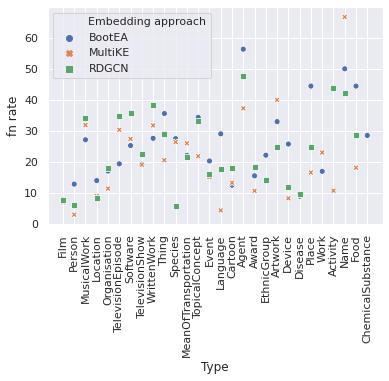

In [6]:
g = sns.scatterplot(x="Type",y="fn rate",hue="Embedding approach",style="Embedding approach",data=combined)
for label in g.get_xticklabels():
    label.set_rotation(90)

In [7]:
def stylize(df):
    cm = sns.cubehelix_palette(5, as_cmap=True)
    return df.style.background_gradient(cmap=cm, axis=1)

In [8]:
bootea = combined[combined["Embedding approach"]=="BootEA"]
rdgcn = combined[combined["Embedding approach"]=="RDGCN"]
multike = combined[combined["Embedding approach"]=="MultiKE"]

In [9]:
stats.pearsonr(bootea[bootea["fn rate"].notna()]["fn rate"], bootea[bootea["fn rate"].notna()]["rate of all"])

(-0.41303601134206613, 0.02892321215160334)

In [10]:
stats.kendalltau(combined[combined["fn rate"].notna()]["fn rate"], combined[combined["fn rate"].notna()]["rate of all"])

KendalltauResult(correlation=-0.17055461349827122, pvalue=0.024359491993652147)

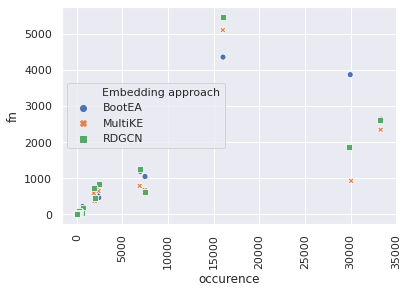

In [11]:
g = sns.scatterplot(x="occurence",y="fn", hue="Embedding approach", style="Embedding approach", data=combined)
for label in g.get_xticklabels():
    label.set_rotation(90)

<AxesSubplot:>

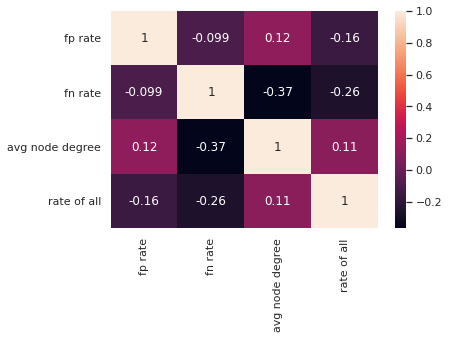

In [12]:
sns.heatmap(combined[["fp rate","fn rate","avg node degree","rate of all"]].corr(method="spearman"), annot=True)

In [22]:
kg1_ent_id_files, kg2_ent_id_files, pred_files = _get_files(embedding_approaches[2], dataset_name, "/home/dobraczka/Downloads/git/er-embedding-benchmark/data/")
df = create_typed_predictions(
            kg1_ent_id_files,
            kg2_ent_id_files,
            pred_files,
            type_files,
            "/home/dobraczka/Downloads/git/er-embedding-benchmark/data/OpenEA/typed_links/superclasses.json",
            1,
            False,
        )
entity_degrees = get_entity_node_degrees(f"/home/dobraczka/Downloads/git/er-embedding-benchmark/data/OpenEA/{dataset_name}")

Load cached /tmp/D_W_15K_V1rdgcn_random forest 500_SimAndEmb_test_pred.pkl


In [23]:
df

,left_types,left_uri,pred,right_types,right_uri,val
0,http://dbpedia.org/ontology/Organisation,http://dbpedia.org/resource/Bradford_Bulls,1,http://dbpedia.org/ontology/Organisation,http://www.wikidata.org/entity/Q2352689,1
1,http://dbpedia.org/ontology/Film,http://dbpedia.org/resource/Blast_from_the_Pas...,0,http://dbpedia.org/ontology/Person,http://www.wikidata.org/entity/Q489831,0
2,http://dbpedia.org/ontology/TelevisionShow,http://dbpedia.org/resource/Gosei_Sentai_Daira...,0,http://dbpedia.org/ontology/Film,http://www.wikidata.org/entity/Q3549469,0
3,http://dbpedia.org/ontology/Person,http://dbpedia.org/resource/Shashi_Kapoor,1,http://dbpedia.org/ontology/Person,http://www.wikidata.org/entity/Q379171,1
4,http://dbpedia.org/ontology/Person,"http://dbpedia.org/resource/Jim_O'Neill,_Baron...",0,http://dbpedia.org/ontology/Person,http://www.wikidata.org/entity/Q7611764,0
5,http://dbpedia.org/ontology/Film,http://dbpedia.org/resource/We're_No_Angels_(1...,1,http://dbpedia.org/ontology/Film,http://www.wikidata.org/entity/Q617833,1
6,http://dbpedia.org/ontology/Film,http://dbpedia.org/resource/Tom_Sawyer_(1930_f...,1,http://dbpedia.org/ontology/Film,http://www.wikidata.org/entity/Q2405363,1
7,http://dbpedia.org/ontology/Film,http://dbpedia.org/resource/It's_Forever_Sprin...,1,http://dbpedia.org/ontology/Film,http://www.wikidata.org/entity/Q4025310,1
8,http://dbpedia.org/ontology/MusicalWork,http://dbpedia.org/resource/Love_Don't_Live_He...,0,http://dbpedia.org/ontology/MusicalWork,http://www.wikidata.org/entity/Q7238100,0
9,http://dbpedia.org/ontology/Film,http://dbpedia.org/resource/Escape_to_Glory,1,http://dbpedia.org/ontology/Film,http://www.wikidata.org/entity/Q3798256,1


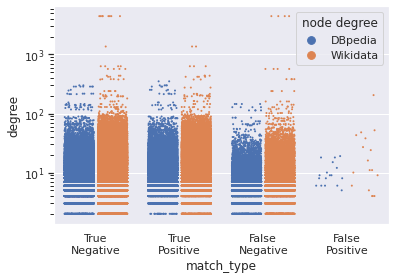

In [31]:
with sns.axes_style("darkgrid",{"ytick.left":True}):
    g = sns.stripplot(x="match_type",y="degree",hue="node degree",dodge=True,jitter=0.35,size=2,data=melted[0])
    g.set_yscale("log")

In [ ]:
sns.boxenplot(x="match_type",y="degree",hue="node degree",data=melted)

In [ ]:
def set_errors(df, pred, val):
    if (df["pred"] == pred) & (df["val"] == val):
        return 1
    else:
        return 0

In [ ]:
def calc_measures(data):
    df = data.copy()
    df["fn"] = df.apply(set_errors, args=(0,1), axis=1)
    df["fp"] = df.apply(set_errors, args=(1,0), axis=1)
    df["tp"] = df.apply(set_errors, args=(1,1), axis=1)
    df["tn"] = df.apply(set_errors, args=(0,0), axis=1)
    summed = (df.groupby("left_types").sum() + df.groupby("right_types").sum()) / 2
    summed["prec"] = summed["tp"] / (summed["tp"]+summed["fp"])
    summed["rec"] = summed["tp"] / (summed["tp"]+summed["fn"])
    summed["fm"] = 2*(summed["prec"]*summed["rec"]/(summed["prec"]+summed["rec"]))
    return summed[["prec","rec","fm"]]

In [ ]:
measured_df_bootea = calc_measures(df)

In [ ]:
measured_df_multike = calc_measures(df)

In [ ]:
measured_df_rdgcn = calc_measures(df)

In [ ]:
measured = []
for d in dfs:
    measured.append(calc_measures(d))

In [ ]:
#A.columns = pd.MultiIndex.from_product([["BootEA"], measured_df_bootea.columns])
#B.columns = pd.MultiIndex.from_product([['MultiKE'], measured_df_multike.columns])
#C.columns = pd.MultiIndex.from_product([['RDGCN'], measured_df_rdgcn.columns])

mult = pd.concat(measured, axis = 1, keys=(["BootEA","MultiKE","RDGCN"]))

In [ ]:
final = mult.sort_index(axis=1, level=1).swaplevel(axis=1)

In [ ]:
final = final.reset_index().rename(columns={"left_types":"Type"})
#final["Type"] = [x.split("/")[-1].split("#")[-1] for x in final["Type"].astype(str)]
final = final.set_index("Type").drop("index",level=0,axis=1)

In [ ]:
final.fillna(-1).style.background_gradient(cmap='Greens',axis=1)

In [ ]:
def get_nds(vector_type):
    entity_degrees = get_entity_node_degrees(f"/home/dobraczka/Downloads/git/er-embedding-benchmark/data/OpenEA/{dataset_name}")
    dfs = []
    for e in embedding_approaches:
        kg1_ent_id_files, kg2_ent_id_files, pred_files = _get_files(e, dataset_name, "/home/dobraczka/Downloads/git/er-embedding-benchmark/data/", vector_type)
        df = create_typed_predictions(
                kg1_ent_id_files,
                kg2_ent_id_files,
                pred_files,
                type_files,
                "/home/dobraczka/Downloads/git/er-embedding-benchmark/data/OpenEA/typed_links/superclasses.json",
            )
        dfs.append(df)
    measured = []
    for d in dfs:
        measured.append(calc_measures(d))
    mult = pd.concat(measured, axis = 1, keys=(["BootEA","MultiKE","RDGCN"]))
    final = mult.sort_index(axis=1, level=1).swaplevel(axis=1)
    final = final.reset_index().rename(columns={"left_types":"Type"})
    final = final.set_index("Type").drop("index",level=0,axis=1)
    melted = final["fm"].reset_index().melt(id_vars=["Type"],value_vars=["BootEA","MultiKE","RDGCN"], var_name="Approach",value_name="F-measure")
    melted = melted.set_index("Type")
    nds = melted.join(average_node_degree(dfs[0],entity_degrees))
    nds.reset_index(inplace=True)
    occ = (dfs[0]["left_types"].value_counts() + dfs[0]["right_types"].value_counts()).to_frame("occurence").reset_index().rename(columns={"index":"Type"})
    return nds.merge(occ, on="Type")

In [ ]:
nds_sim_and_emb = get_nds("SimAndEmb")

In [ ]:
nds_emb = get_nds("OnlyEmb")
nds_sim = get_nds("OnlySim")

In [ ]:
sns.heatmap(nds_sim_and_emb[nds_sim_and_emb["Approach"]=="MultiKE"][["F-measure","node degree","occurence"]].corr(method="spearman"), annot=True)

In [ ]:
sns.heatmap(nds_sim[nds_sim["Approach"]=="MultiKE"][["F-measure","node degree","occurence"]].corr(method="spearman"), annot=True)

In [ ]:
sns.heatmap(nds_emb[nds_emb["Approach"]=="MultiKE"][["F-measure","node degree","occurence"]].corr(method="spearman"), annot=True)

In [ ]:
occ = (dfs[0]["left_types"].value_counts() + dfs[0]["right_types"].value_counts()).to_frame("occurence").reset_index().rename(columns={"index":"Type"})
nds.merge(occ, on="Type")

[(0,
  left_types       http://dbpedia.org/ontology/Organisation
  left_uri       http://dbpedia.org/resource/Bradford_Bulls
  pred                                                    1
  right_types      http://dbpedia.org/ontology/Organisation
  right_uri         http://www.wikidata.org/entity/Q2352689
  val                                                     1
  Name: 0, dtype: object),
 (1,
  left_types                      http://dbpedia.org/ontology/Film
  left_uri       http://dbpedia.org/resource/Blast_from_the_Pas...
  pred                                                           0
  right_types                   http://dbpedia.org/ontology/Person
  right_uri                 http://www.wikidata.org/entity/Q489831
  val                                                            0
  Name: 1, dtype: object),
 (2,
  left_types            http://dbpedia.org/ontology/TelevisionShow
  left_uri       http://dbpedia.org/resource/Gosei_Sentai_Daira...
  pred                             